# Toy Schedules Generation

Generate a population (schedules and attributes). Where every schedule is home -> ACTIVITY -> home, with varying durations. Where ACTIVITY depends on work_status attribute.

In [26]:
from pathlib import Path

import pandas as pd
from numpy.random import choice
import random

from caveat.data.synth import ActivityGen
from caveat.data.utils import generate_population, trace_to_pam
from caveat.evaluate.describe.times import (
    joint_time_distributions_plot,
    times_distributions_plot,
)
from caveat.evaluate.describe.transitions import sequence_prob_plot

In [27]:
n = 10000
p = 0.5

schedules_write_path = Path("tmp/toy_50noisy_schedules.csv")
attributes_write_path = Path("tmp/toy_50noisy_attributes.csv")


In [28]:
pid = []
pids = []
acts = []
starts = []
ends = []
durations = []
work_statuses = []

for i in range(n):
    pid.append(i)
    departure_time = random.randint(300, 600)
    work_duration = random.randint(120, 600)
    home_duration = 1440 - work_duration - departure_time
    t = 0
    work_status = random.choice(["employed", "student", "unemployed"])
    probs = {
        "employed": [p, (1 - p) / 2, (1 - p) / 2],
        "student": [(1 - p) / 2, p, (1 - p) / 2],
        "unemployed": [(1 - p) / 2, (1 - p) / 2, p],
    }
    activity = choice(["work", "education", "other"], p=probs[work_status])
    work_statuses.append(work_status)

    for act, duration in zip(
        ["home", activity, "home"],
        [departure_time, work_duration, home_duration],
    ):
        pids.append(i)
        acts.append(act)
        starts.append(t)
        t += duration
        ends.append(t)
        durations.append(duration)

schedules = pd.DataFrame(
    {
        "pid": pids,
        "act": acts,
        "start": starts,
        "end": ends,
        "duration": durations,
    }
)

attributes = pd.DataFrame(
    {
        "pid": pid,
        "work_status": work_statuses,
    }
)

print(schedules.head())
print(attributes.head())

   pid    act  start   end  duration
0    0   home      0   584       584
1    0  other    584  1172       588
2    0   home   1172  1440       268
3    1   home      0   590       590
4    1   work    590  1037       447
   pid work_status
0    0     student
1    1  unemployed
2    2    employed
3    3     student
4    4     student


In [29]:
schedules_write_path.parent.mkdir(exist_ok=True)
attributes_write_path.parent.mkdir(exist_ok=True)
schedules.to_csv(schedules_write_path, index=False)
attributes.to_csv(attributes_write_path, index=False)

In [30]:
def describe_col(population, col: str) -> pd.DataFrame:
    description = population.groupby("act")[col].describe()[
        ["count", "mean", "std", "min", "max"]
    ]
    description["attribute"] = col
    return description


def describe_cols(population, cols: list[str]) -> pd.DataFrame:
    description = pd.concat(
        [describe_col(population, c) for c in cols], ignore_index=False
    )
    description = description.reset_index().set_index(["attribute", "act"])
    return description


describe_cols(schedules, ["start", "end", "duration"]).round()

count   mean    std    min     max
attribute act                                            
start     education   3352.0  451.0   87.0  300.0   600.0
          home       20000.0  404.0  420.0    0.0  1195.0
          other       3348.0  449.0   86.0  300.0   600.0
          work        3300.0  450.0   86.0  300.0   600.0
end       education   3352.0  807.0  164.0  425.0  1190.0
          home       20000.0  945.0  499.0  300.0  1440.0
          other       3348.0  810.0  163.0  434.0  1188.0
          work        3300.0  808.0  164.0  427.0  1195.0
duration  education   3352.0  356.0  138.0  120.0   600.0
          home       20000.0  541.0  159.0  245.0  1015.0
          other       3348.0  361.0  139.0  120.0   600.0
          work        3300.0  358.0  138.0  120.0   600.0

In [31]:
def time_distributions(population: pd.DataFrame, mapping: dict):
    starts = {k: [] for k in mapping.values()}
    ends = {k: [] for k in mapping.values()}
    durations = {k: [] for k in mapping.values()}
    for act, acts in population.groupby("act"):
        starts[act] = list(acts.start)
        ends[act] = list(acts.end)
        durations[act] = list(acts.duration)
    return starts, ends, durations

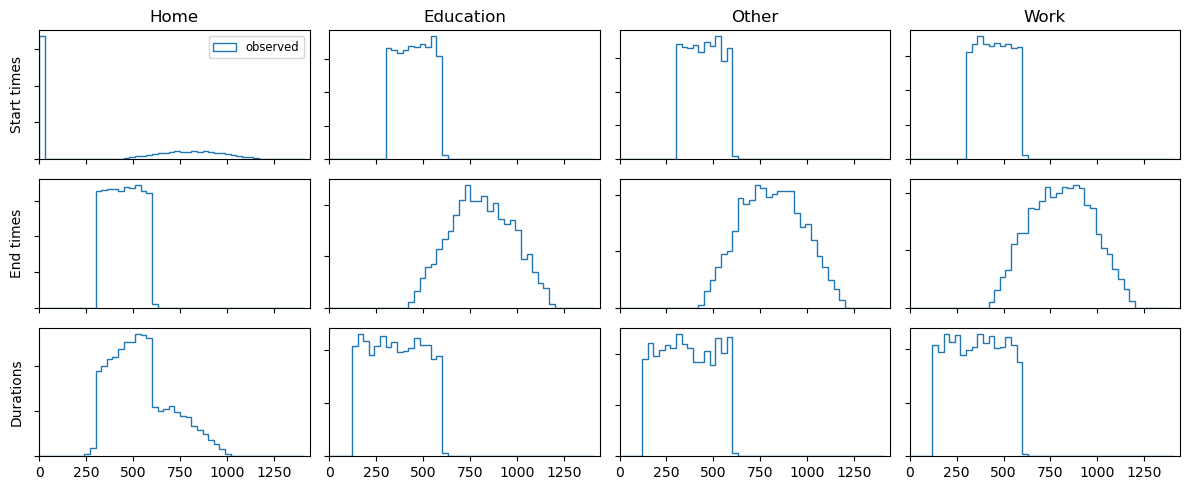

In [32]:
_ = times_distributions_plot(schedules, ys={})

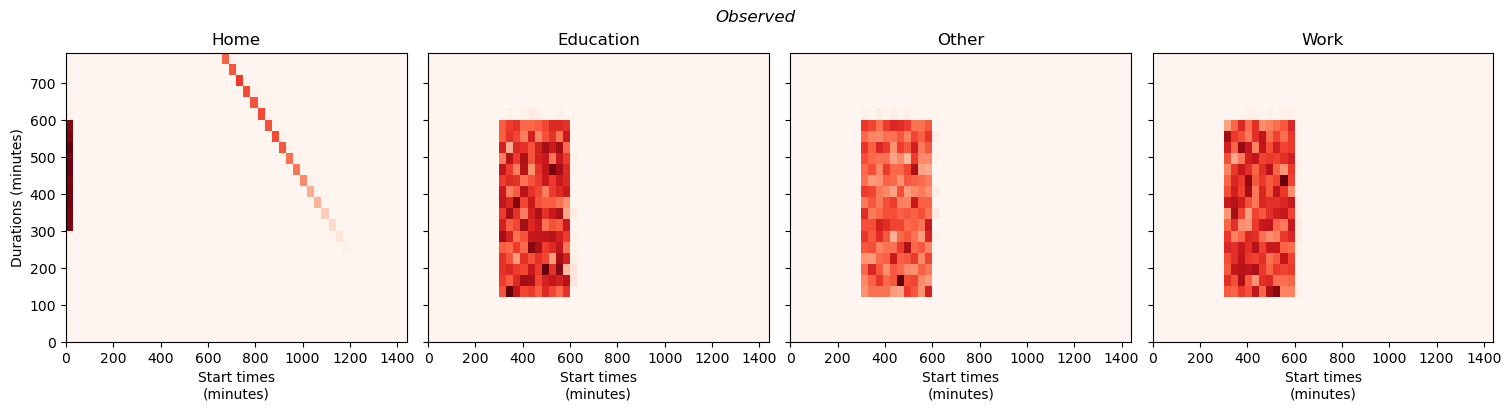

In [33]:
_ = joint_time_distributions_plot(schedules, ys={})

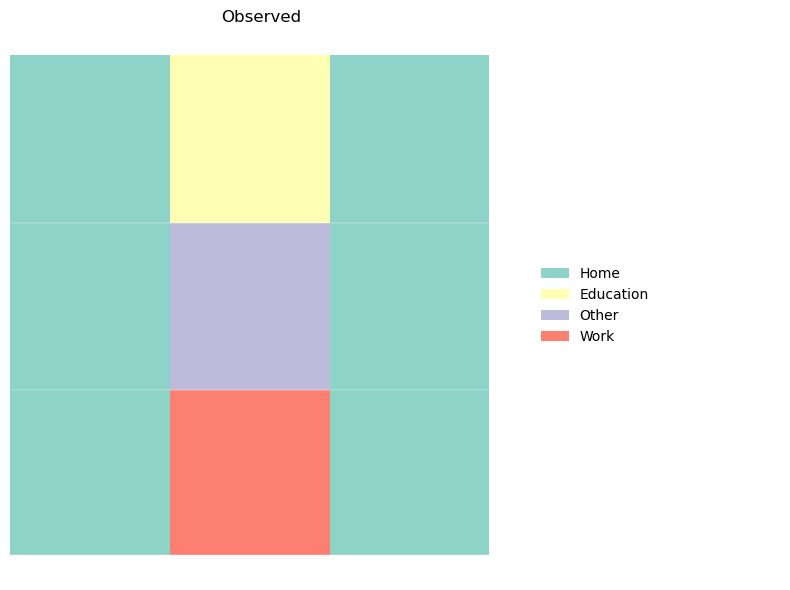

In [34]:
_ = sequence_prob_plot(schedules, ys={}, figsize=(8, 6))